In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, plot_roc_curve, confusion_matrix

In [2]:
data_path = "data/creditcard.csv"
df = pd.read_csv(data_path)

In [3]:
normal = df[df.Class==0].sample(frac=0.5, random_state=2020).reset_index(drop=True)
anomaly = df[df.Class==1]

In [4]:
print(f"Normal : {normal.shape}")
print(f"Anomaly : {anomaly.shape}")

Normal : (142158, 31)
Anomaly : (492, 31)


In [6]:
normal_train, normal_test = train_test_split(normal, test_size=0.2, random_state=2020)
anomaly_train, anomaly_test = train_test_split(anomaly, test_size=0.2, random_state=2020)

In [7]:
normal_train, normal_validate = train_test_split(normal_train, test_size=0.25, random_state=2020)
anomaly_train, anomaly_validate = train_test_split(anomaly_train, test_size=0.25, random_state=2020)

In [8]:
x_train = pd.concat((normal_train, anomaly_train))
x_test = pd.concat((normal_test, anomaly_test))
x_validate = pd.concat((normal_validate, anomaly_validate))

y_train = np.array(x_train["Class"])
y_test = np.array(x_test["Class"])
y_validate = np.array(x_validate["Class"])

x_train = x_train.drop("Class", axis=1)
x_test = x_test.drop("Class", axis=1)
x_validate = x_validate.drop("Class", axis=1)

In [10]:
scaler = StandardScaler()
scaler.fit(pd.concat((normal, anomaly)).drop("Class", axis=1))

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_validate = scaler.transform(x_validate)

# 데이터 스케일링. 원래는 fit도 훈련 데이터만 사용해서 해야하는데 책에서는 전체를 다 사용함

In [11]:
sk_model = LogisticRegression(random_state=None, max_iter=400, solver="newton-cg").fit(x_train, y_train)

In [12]:
eval_acc = sk_model.score(x_test, y_test)

In [13]:
preds = sk_model.predict(x_test)
auc_score = roc_auc_score(y_test, preds)

In [14]:
print(f"Auc Score : {auc_score:.3%}")
print(f"Eval Accuracy : {eval_acc:.3%}")

Auc Score : 84.331%
Eval Accuracy : 99.867%


Text(0.5, 15.0, 'Predicted')

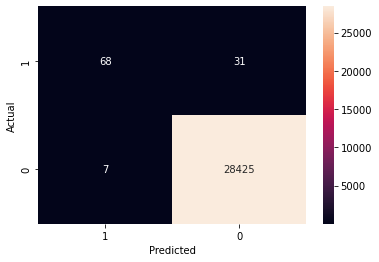

In [15]:
conf_matrix = confusion_matrix(y_test, preds)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [17]:
anomaly_weights = [1, 5, 10, 15]
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=2020)

In [19]:
# 검증
logs = []

for f in range(len(anomaly_weights)):
    fold = 1
    accuracies = []
    auc_scores = []
    for train, test in kfold.split(x_validate, y_validate):
        weight = anomaly_weights[f]
        class_weights = {
            0:1,
            1:weight
        }

        sk_model = LogisticRegression(max_iter=400, solver="newton-cg", class_weight=class_weights).fit(x_validate[train], y_validate[train])

        print('-'*40)
        print(f"\nfold {fold}\nAnomaly Weight: {weight}")
        eval_acc = sk_model.score(x_validate[test], y_validate[test])
        preds = sk_model.predict(x_validate[test])

        try:
            auc_score = roc_auc_score(y_validate[test], preds)
        except:
            auc_score = -1

        print(f"AUC: {auc_score}\neval_acc: {eval_acc}")

        accuracies.append(eval_acc)
        auc_scores.append(auc_score)

        log = [sk_model, x_validate[test], y_validate[test], preds]
        logs.append(log)
        fold += 1

    print("\nAverages : ")
    print("Accuracy :", np.mean(accuracies))
    print("AUC :", np.mean(auc_score))
    print("Best :")
    print("Accuracy :", np.max(accuracies))
    print("AUC :", np.max(auc_score))

----------------------------------------

fold 1
Anomaly Weight: 1
AUC: 0.8
eval_acc: 0.9985982127212195
----------------------------------------

fold 2
Anomaly Weight: 1
AUC: 0.8568790049001132
eval_acc: 0.998422712933754
----------------------------------------

fold 3
Anomaly Weight: 1
AUC: 0.8179179195189047
eval_acc: 0.9980722046968104
----------------------------------------

fold 4
Anomaly Weight: 1
AUC: 0.8682452129973255
eval_acc: 0.9987732211706976
----------------------------------------

fold 5
Anomaly Weight: 1
AUC: 0.8528532875621686
eval_acc: 0.9989484752891693

Averages : 
Accuracy : 0.9985629653623302
AUC : 0.8528532875621686
Best :
Accuracy : 0.9989484752891693
AUC : 0.8528532875621686
----------------------------------------

fold 1
Anomaly Weight: 5
AUC: 0.8748241603657465
eval_acc: 0.9987734361310671
----------------------------------------

fold 2
Anomaly Weight: 5
AUC: 0.9515893956527202
eval_acc: 0.9980722046968104
----------------------------------------

fold

In [20]:
sk_model, x_val, y_val, preds = logs[11]

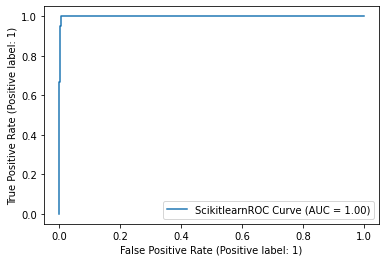

In [21]:
roc_plot = plot_roc_curve(sk_model, x_val, y_val, name="ScikitlearnROC Curve")

Text(0.5, 15.0, 'Predicted')

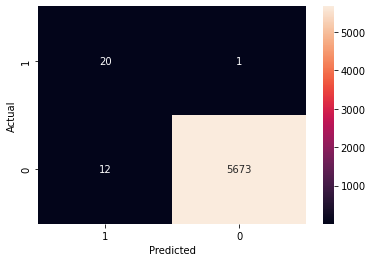

In [22]:
conf_matrix = confusion_matrix(y_val, preds)
ax = sns.heatmap(conf_matrix, annot=True, fmt='g')
ax.invert_xaxis()
ax.invert_yaxis()
plt.ylabel('Actual')
plt.xlabel('Predicted')

# 최적 파라미터 조합일 때의 컨퓨전 매트릭스. 디폴트 파라미터일때보다 더 나은 결과를 보여줌